In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sympy import *
from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness
from IPython.display import Image
from gplearn.functions import make_function

# Generation of a detailled fitting function using Symbolic Regression

## Already existing function

Different methods exists when it comes to feature extraction.<br>
One of them is to fit each light curve using a given mathematical function and using the parameters of the fit as a feature.<br>
A commonly used function for fitting transient light curves is called Bazin : https://arxiv.org/pdf/0904.1066.pdf .

It is a 5 parameters function that can describe very well a rising then decreasing light curve, as shown below :

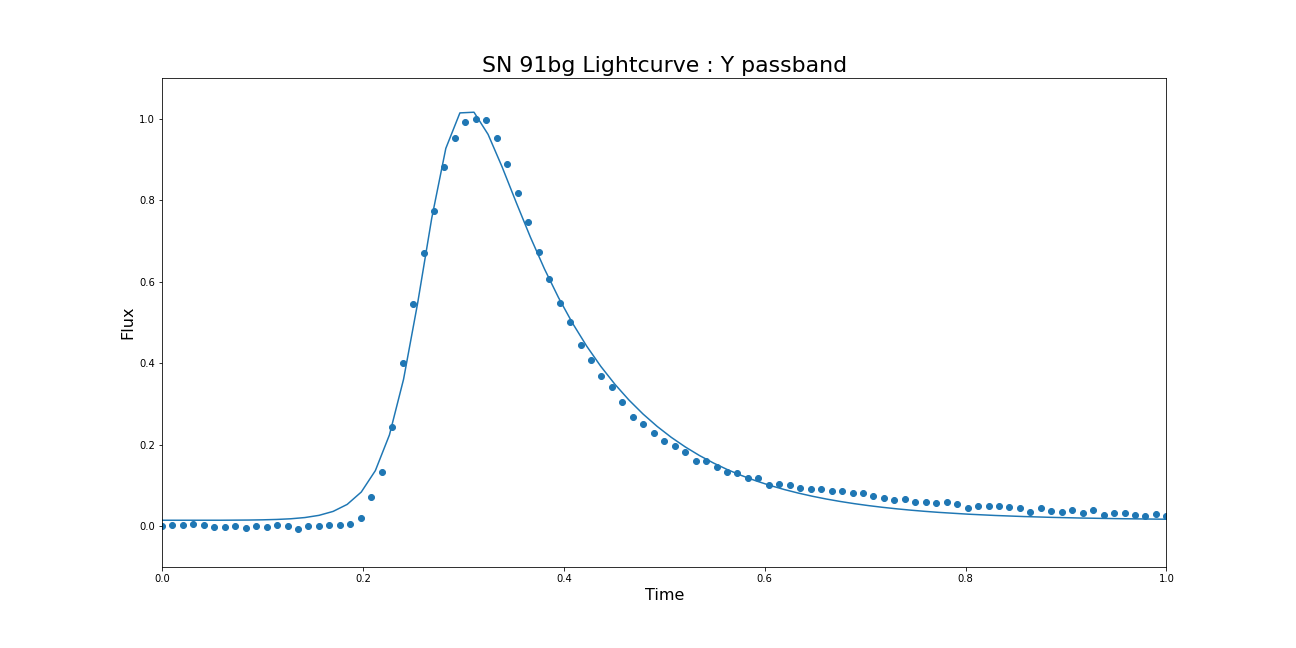

In [6]:
Image(filename='Images/Bazin_ex1.png',width=1100) 

The major flaw of the function is that is uncaplable of capturing details of a light curve. For a example a lightcurve that displays a second bump on it's falling part will be fitted the same way as the above example.<br> Consequently, if the function treats them in the same way, we cannot expect points in the parameter space to be separated.<br>

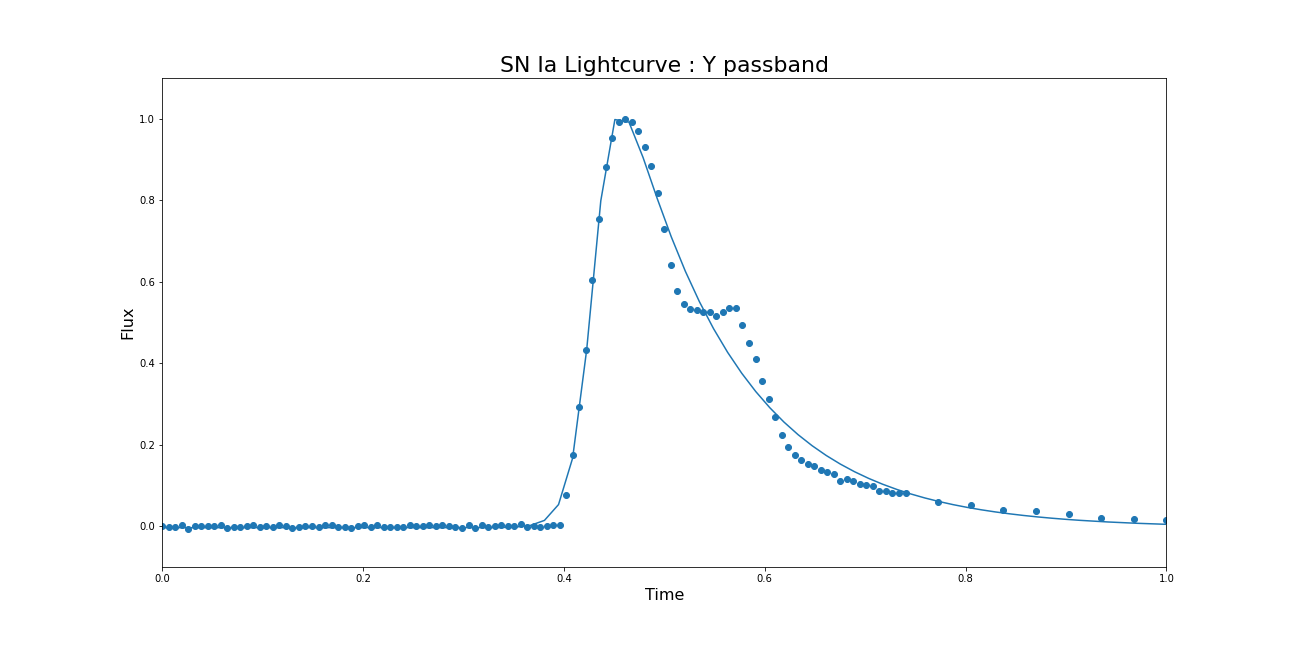

In [7]:
Image(filename='Images/Bazin_ex2.png',width=1100) 

This is why we attempt to create a new function that can capture such details. To do so, we will be using symbolic regression, and in particular GPlearn : https://gplearn.readthedocs.io/en/stable/ <br>
The database used for this work is RESSPECT, which is a simulation database. It provides perfectly sampled light curves, which will easen the task of describing a function for the symbolic regression.

## Set up the database

In [8]:
data_raw = pd.read_csv('data/RESSPECT_PERFECT_LIGHTCURVE.csv')
meta_raw = pd.read_csv('data/RESSPECT_PERFECT_HEAD.csv')

all_obj = np.unique(data_raw['SNID'])
data_raw.head()

,SNID,MJD,FLT,FLUXCAL,FLUXCALERR,SNR
0,3228.0,53000.0,u,-0.097085,0.141841,-0.684463
1,3228.0,53000.0,g,0.064044,0.142066,0.450804
2,3228.0,53000.0,r,0.193542,0.142521,1.357985
3,3228.0,53000.0,i,0.359073,0.143101,2.509235
4,3228.0,53000.0,z,-0.065577,0.141841,-0.462332


The database is a simulation of LSST, thus each light curves exist in 6 different passband : u, g, r, i, z, Y <br>
Before doing anything, we will normalize both flux and time with 1 as maximum for each lightcurve. Eventhough it seems radical, it will provide a constant environement to create and test our function. <br>

In [9]:
# Normalize flux 
maxtable = data_raw.pivot_table(index="FLT", columns="SNID", values="FLUXCAL",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, data_raw, on=["SNID","FLT"])
clean["FLUXCAL"] = clean["FLUXCAL"]/clean[0]
clean["FLUXCALERR"] = clean["FLUXCALERR"] / clean[0]
clean = clean.drop([0],axis=1)

# Shift mjd
mintable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='min')
mindf = pd.DataFrame(data=mintable.unstack())
clean = pd.merge(mindf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]-clean[0]
clean = clean.drop([0],axis=1)

# Normalize mjd
maxtable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]/clean[0]
clean = clean.drop([0],axis=1)

(0.0, 1.0)

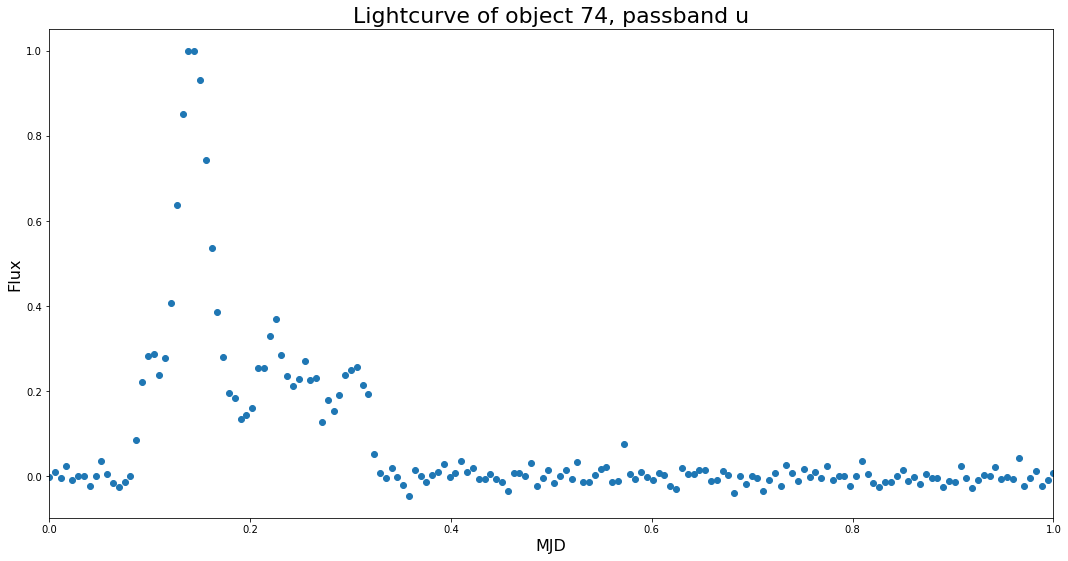

In [13]:
obj = clean[(clean['SNID']==74)&(clean['FLT']=='u')]
mjd = obj['MJD']
flux = obj['FLUXCAL']
fluxerr = obj['FLUXCALERR']

# Add zero points far away
mjd = mjd.append(pd.Series([-1,-2,-3,2,3,4]),ignore_index=True)
flux = flux.append(pd.Series([0,0,0,0,0,0]),ignore_index=True)
fluxerr = fluxerr.append(pd.Series([0.001]*6),ignore_index=True)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)

plt.title('Lightcurve of object 74, passband u',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.xlim(0,1)

Choosing a random object we can see that both flux and time are less or equal to 1 <br>
NB : Flux is divided by maximum value, thus negative values can still exist and even be less than -1.<br>

This lightcurve looks perfect for our task. It display a second bump while still having some noise : we can try to fit it using symbolic regression ! <br>
One last idea to consider before using GPlearn is to add zero flux points far away fron 0 mjd and 1 mjd. Indeed we want our future function to be somewhat stable and an obvious behaviour it should have is to be at zero towards + and - infinity. By adding zero points far away we will "force" the fit to act this way. <br>
This is what as been done in the previous cell, and the full display of the light curve now looks like that :

Text(0, 0.5, 'Flux')

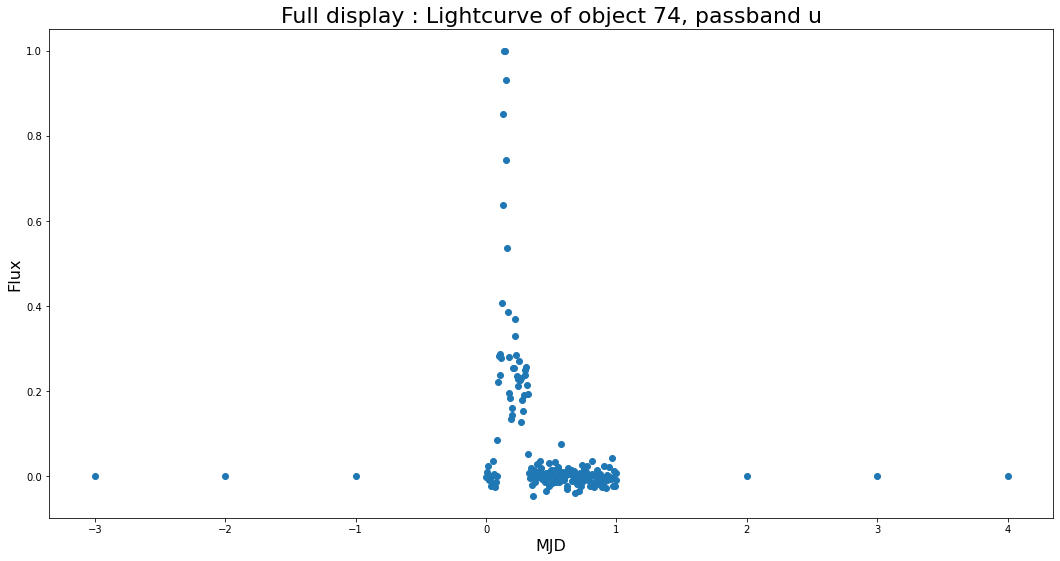

In [14]:
plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)

plt.title('Full display : Lightcurve of object 74, passband u',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)

## Fit using GPlearn

### The main idea

The main idea is to fit the previous lightcurve with a symbolic regression. This will output a mathematical function arbitrarily complex. The assumption is that if the function is capable of describing this particular light curve, it is also capable of fitting similar curves by tweaking constants of the fit. <br>
A simple example of how this method could find a linear function is displayed below :

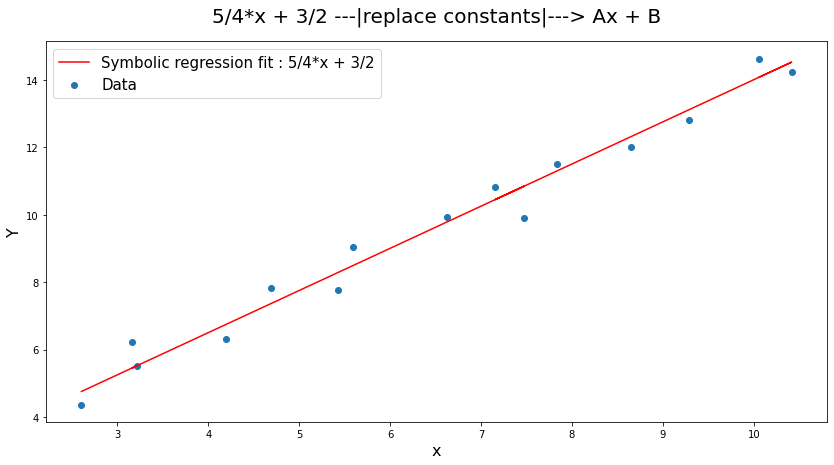

In [15]:
pts = 15
x_line = np.linspace(2,10,pts)+np.random.rand(pts)
y_line = np.linspace(4,14,pts)+np.random.rand(pts)

plt.figure(figsize=(14,7));
plt.scatter(x_line,y_line,label='Data')
plt.plot(x_line, 3/2 + 5*x_line/4,c='red',label='Symbolic regression fit : 5/4*x + 3/2')

plt.title('5/4*x + 3/2 ---|replace constants|---> Ax + B',size = 20,pad=20)
plt.xlabel('x',size = 16)
plt.ylabel('Y',size = 16)
plt.legend(fontsize=15)

### Set up GPlearn

In order to use the created function we create dictionnary that convert GPlearn syntax to equation

In [16]:
converter = {
'sub': lambda x, y : x - y,
'div': lambda x, y : x/y,
'mul': lambda x, y : x*y,
'add': lambda x, y : x + y,
'neg': lambda x    : -x,
'pow': lambda x, y : x**y,
'sin': lambda x    : sin(x),
'cos': lambda x    : cos(x),
'inv': lambda x: 1/x,
'sqrt': lambda x: x**0.5
}

Symbolic regression uses a set of operation to generate a function. In addition to the basic 'add', 'sub', 'mul', 'div' already implemented in GPlearn, we will add custom operations. <br>
Because we have knowledge about what the curve looks like we add exponential as a possible operation.<br>
Also we know that the function should equal 0 towards +- infinity, we will therefore add a step operation that might be used to do this job.

In [17]:
def _protected_exponent(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 10, np.exp(x1), np.exp(10))
     
protected_exponent = make_function(function=_protected_exponent,
                        name='exp', arity=1)


def _step(x1):
    return np.where(x1 > 0, x1, 0)
    
step = make_function(function=_step, name='step', arity=1)

Finaly let's set create a custom cost function, so that we can have another lever to act on the evolution

In [18]:
def _mape(y, y_pred, w):
    
    diffs = (np.abs(y - y_pred))**2
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

### Start the symbolic regression

From there, there is an infinite number of way to parametrise the symbolic regression. The most crucial parameter to tweak is the parsimony_coefficient. It is a float value that penalises the created function based on it's lenght. <br>
Indeed, the ideal function should be small in the sense that it should contain as few free constants as possible. Since we want to do better than bazin we expect more than 5 parameters, so we ideally aim at 6 or 7. <br>

If we try to apply a parsimony_coefficient = 0, the function will quickly grow large, having hundreds of parameters and completly overfitting the curve. One the other hand, if we choose a parsimony_coefficient too big, it will just output a straight line to zero since we do not allow enough freedom. <br>

A tool that will be very handy is the warm start. It allows to evolve the function with a given parametrisation, and once it stopped, modify the parametrisation and continue evolving the same population.<br> The strategy will then be to start with a very low parsimony_coefficient,thus producing a population that overfits the curve. We then gradually increase the parsimony_coefficient which will result in a smoothing of the curves and a simplification of the equations. At some point the equation will be at it's simplest form and increasing parsimony_coefficient will not do anything, but if the parsimony_coefficient continues to increase and reaches a certain point, all the population will "snap" and collapse into a zero line. <br>

NB : This process is random and thus,if you apply this method on twice, using with two different seeds, you might end up with completely different results. Nethertheless it seems that we have enough generations at each step, the final equation will always be very similar 

In [16]:
# USE THIS CELL TO GENERATE YOUR FIRST FIT 

# Evolution parameters 
###############################################
population_size=600
generations=200
parsimony_coefficient = 0.0001
verbose = 1

p_crossover=0.25
p_subtree_mutation=0.15
p_hoist_mutation=0.30
p_point_mutation=0.30

tournament_size=10

function_set = ['add', 'sub', 'mul', 'div',protected_exponent,step]
################################################

gp = SymbolicRegressor(population_size=population_size,function_set=function_set,
                       generations=generations,parsimony_coefficient=parsimony_coefficient,
                       random_state=42,verbose=verbose,metric=mape,p_crossover=p_crossover,
                      p_subtree_mutation=p_subtree_mutation,p_hoist_mutation=p_hoist_mutation,
                      p_point_mutation=p_point_mutation,warm_start=False,stopping_criteria=0.1)
    
gp.fit(pd.DataFrame(data = mjd), flux)

In [51]:
# USE THIS CELL IF YOU WANT TO KEEP EVOLVING YOUR FUNCTION

gp.set_params(generations=400, warm_start=True,parsimony_coefficient = 0.25)

gp.fit(pd.DataFrame(data = mjd), flux)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
3000    10.63      4.74621e+09       11         0.744488              N/A     13.64m
3001    10.66      1.26215e+10       11         0.744488              N/A     14.18m
3002    10.80      2.11702e+08       11         0.744488              N/A     13.70m
3003    10.81      1.16575e+07       11         0.744488              N/A     13.71m
3004    10.39      2.70262e+08       11         0.744488              N/A     13.70m
3005    10.61      1.30206e+08       11         0.744488              N/A     13.61m
3006    10.90      3.32257e+09       11         0.744488              N/A     14.11m
3007    10.92      3.73698e+09       11         0.744488              N/A     14.03m
3008    10.54      9.73821e+09       11         0.744488              N/A  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div',
                  generations=4000,
                  metric=<gplearn.fitness._Fitness object at 0x7f30d239ef60>,
                  p_crossover=0.2, p_hoist_mutation=0.2, p_point_mutation=0.15,
                  p_subtree_mutation=0.4, parsimony_coefficient=0.25,
                  population_size=600, random_state=42, stopping_criteria=0.1,
                  verbose=1, warm_start=True)

You can then visualise the equation and see how the plot looks like :

In [ ]:
# Print the mathematical equation of the function
sympify((str(gp._program)), locals=converter)

In [ ]:
#Plot your fit

x_fit = np.linspace(mjd.min(),mjd.max(),500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux,label='data')

plt.plot(x_fit,gp.predict(pd.DataFrame(data = x_fit)),label='Symbolic Regression fit')

plt.title('Best generated function',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(0,1)
plt.legend()

## Implementing the function

This iterative work has been done and led to this fit :

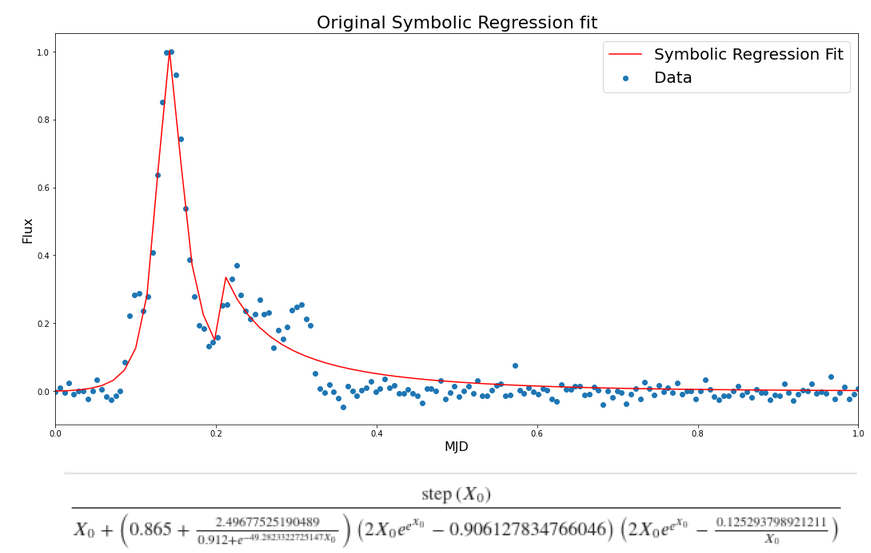

In [20]:
Image(filename='Images/result_symbolic.png',width=1100) 

Yaay, the fit is very nice (if we look away form the double exponentials at least)! It describes the second bump in a simple way and eventhough it is not physicaly accurate, it doesn't matter, since we just want to capture the information that something different is happening here.<br>
Now it is time to convert this specific fit into a general function. Here are making an hypothese : all the floats of the fit will be considered as free parameters but the integers (in this case the two "2"s) are left as they are. We suppose that because the integer are not tuned and thus doesn't seem specific to this fit. This will allow us to limit the number of free paramaters.<br>
This adds up to a total of 6 free parameters. To theses we need to add one extra parameter that simply correspond to the shift on the x-axis so that the function can fit independently of their position. In the end 7 parameters are requiered, which is within what we were hoping for.<br> Let's now write this function and we will be done. In another notebook we will see how this function acts when used on data it was not trained on.


In [48]:
def SR_func(x,p1,p2,p3,p4,p5,p6,shift):
    
    
    x = x+shift+0.13
    
    protex = np.where(abs(x) > 0.001, x, (np.sign(x)+0.00001)*0.001)
    double_expo = 2*x*_protected_exponent(_protected_exponent(x))
    
    den_A = p3 +_protected_exponent(p4*x)
    protec_den_A = np.where(abs(den_A) > 0.001, den_A, (np.sign(den_A)+0.0001)*0.001)
    A = p1 + p2/protec_den_A
    
    B = double_expo - p5
    
    C = double_expo - p6/protex
    
    full_den = x + A*B*C
    protec_full_den = np.where(abs(full_den) > 0.001, full_den, (np.sign(full_den)+0.0001)*0.001)
    
    return _step(x)/protec_full_den

    

guess_bazin = [1, mjd[np.argmax(flux)], 0.2, -0.05, 0]
guess_ego = [0.865,2.496,0.912,-49.28,0.906,0.125,-mjd[np.argmax(flux)]]
